# Problem 3: Haar wavelets
Prof. V. I. Morgenshtern

Solver: A. Regensky, K. Mayer

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import logging
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

1\. Show that the Haar wavelet transform of a signal of length $N = 2^J$ can be computed in $O(N)$ computations. Implement the corresponding algorithm.


In [2]:
# Helper Functions

def isPower2(N):
    """Ref. https://stackoverflow.com/questions/29480680/finding-if-a-number-is-a-power-of-2-using-recursion
    The binary representation of every number and the (number-1) share at least a single 1 bit, except if the 
    number is a power of two. Further, all negative numbers share the leading bit, so are excluded by this method."""
    
    N = int(N)
    return (((N & (N-1)) == 0) and N != 0)

def pad(signal):
    """Returns padded signal or original. Depending on the signal length.
    Padding is neccessary if the signal length is not a power of two."""
    
    if(not isPower2(signal.shape[0])):
        pads = int(2**np.ceil(np.log2(signal.shape[0])) - signal.shape[0])
        padding = np.zeros(pads)
        padded_signal = np.hstack((signal,padding))
        logging.warning("Padded the signal with {0} zeros to obtain signal with length N=2^J={1}.".format(pads,padded_signal.shape[0]))
        return padded_signal
    else:
        return signal
    
def upsample(signal,N=2):
    """Returns signal upsampled by a factor N"""
    upsampled_signal = np.zeros(signal.size*N)
    upsampled_signal[::N]=signal
    return upsampled_signal

def downsample(signal,N=2):
    """Returns signal downsampled by a factor N"""
    return signal[::N] 


The solution is obtained by decomposing the signal using a filter bank and the appropriate quadrature mirror filters for the Haar wavelet. An illustration for a three level decomposition can be found here: 
[<img src="https://upload.wikimedia.org/wikipedia/commons/2/22/Wavelets_-_Filter_Bank.png">](https://en.wikipedia.org/wiki/Discrete_wavelet_transform#Cascading_and_filter_banks)

The filter bank approach consists of a series of convolutions. Since the computational complexity of the convolution is linear, the overall complexity is approximately linear.

In [3]:
# quadrature mirror filters for the Haar wavelet
# For Decomposition
h_analysis = (1/np.sqrt(2))*np.array([-1,1]) 
g_analysis = (1/np.sqrt(2))*np.ones(2)

# For Reconstruction 
h_synthesis = h_analysis[::-1]
g_synthesis = g_analysis[::-1]

#### Decomposition

In [4]:
def decomposition_step(a):
    """Returns the approximation and the wavelet coefficient for one level."""


    # convolutions
    a_new = np.convolve(a,g_analysis,mode='valid') # Low freq component
    w_new = np.convolve(a,h_analysis,mode='valid') # High freq component

    a_new = downsample(a_new,N=2)
    w_new = downsample(w_new,N=2)
    
    return a_new, w_new 

def multilevel_dwt(signal):
    """Returns the transformed signal and the coefficients 
    of the decomposed signal for all levels.
    The signal length must be a power of two!"""
    
    signal = pad(signal)
    n = len(signal)
    levels = int(np.log2(n))
    
   
    coefficients = []
    a = signal
    
    for i in range(levels):
        a, w = decomposition_step(a)
        if i != levels-1:
            coefficients = np.hstack((w,coefficients))   
        else:
            coefficients = np.hstack((a,w,coefficients))   
    return coefficients


#### Reconstruction

In [5]:
def reconstruction_step(a,w):
    """Returns the reconstructed signal for single 
    level using low frequency component `a` and high 
    frequency component `w`."""

    a = upsample(a, N=2)
    w = upsample(w, N=2)

    # convolutions
    a_new = np.convolve(a,g_synthesis,mode='same') + np.convolve(w,h_synthesis,mode='same')
  
    return a_new

def multilevel_idwt(coefficients):
    """Returns the reconstructed signal from wavelet coefficients.
    The signal length must be a power of two!"""

    coefficients = pad(coefficients)
       
    a = coefficients[0]
    high = coefficients[1:] # Remaining high freq. coefficients

    while high.size !=0:
        # Split high freq. coefficients of the current level
        w,high = high[:a.size],high[a.size:]

        a = reconstruction_step(a,w)      
    return a

2\. Use your algorithm to compute the Haar wavelet transform of the following functions on the interval $[−0.5, 0.5]$. (The functions should be sampled to have $2^J$ sampling points).
* $f_1(t) = \begin{cases} 1\text{,} & \text{if } t<\frac{1}{3} \\ 0\text{,} & \text{otherwise.} \end{cases}$


* $f_2(t) = \sin(t)$

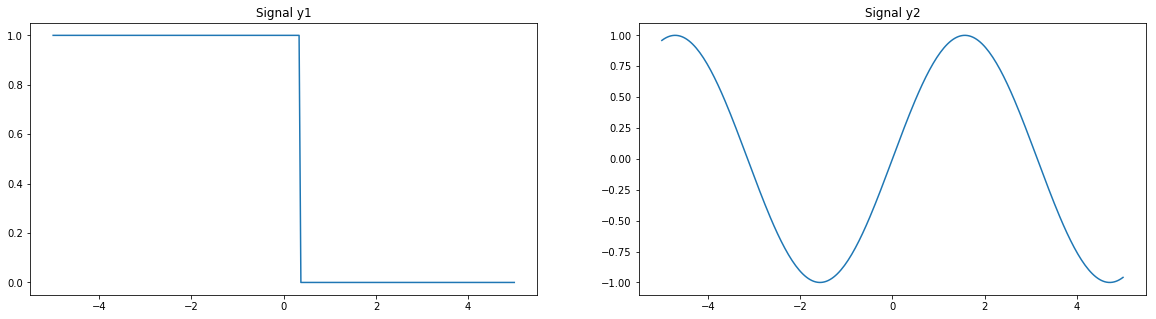

In [6]:
def f1(t):
    return (t<(1./3.)).astype(int)

def f2(t):
    return np.sin(t)

# Generate the sampled signals
t = np.linspace(-5,5,256)
y1 = f1(t)
y2 = f2(t)

# Plot the original signal
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(t,y1)
plt.title('Signal y1')
plt.subplot(1,2,2)
plt.plot(t,y2)
plt.title('Signal y2')
plt.show()


3\. Display the wavelet coefficients for both functions.

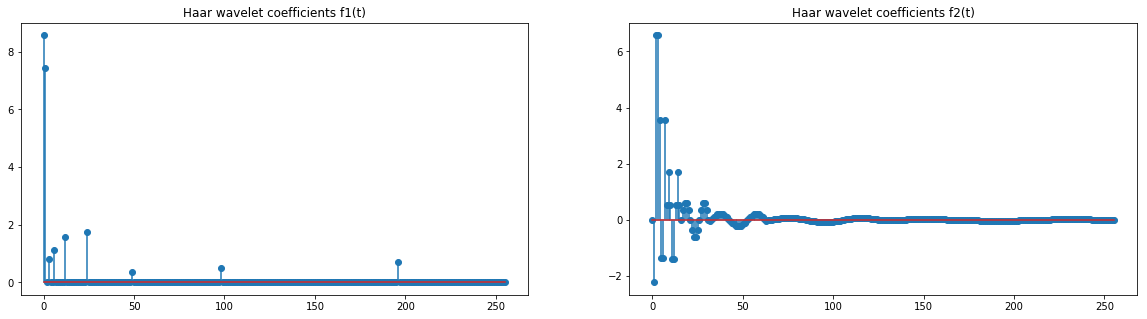

In [7]:
# Transform to Haar wavelet domain

y1_haar = multilevel_dwt(y1)
y2_haar = multilevel_dwt(y2)


plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.stem(y1_haar)
plt.title('Haar wavelet coefficients f1(t)')
plt.subplot(1,2,2)
plt.stem(y2_haar)
plt.title('Haar wavelet coefficients f2(t)')
plt.show()

4\. Make histograms of wavelet coefficient sizes for the two cases. Compare and discuss the approximate sparsity in the wavelet coefficients of the two functions.

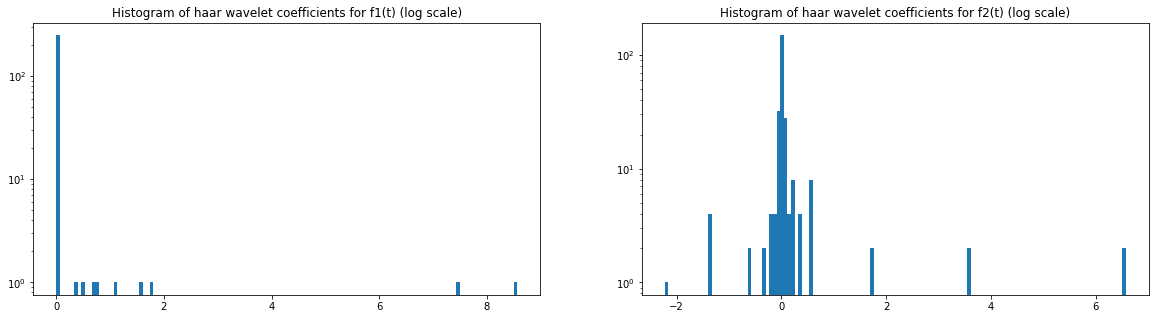

In [8]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(y1_haar,int(y1_haar.shape[0]/2),log=True)
plt.title('Histogram of haar wavelet coefficients for f1(t) (log scale)')
plt.subplot(1,2,2)
plt.hist(y2_haar,int(y2_haar.shape[0]/2),log=True)
plt.title('Histogram of haar wavelet coefficients for f2(t) (log scale)')
plt.show()

5\. Set 50 percent of the smallest wavelet coefficients for both functions to zero. Take the inverse wavelet transform and display the resulting functions.

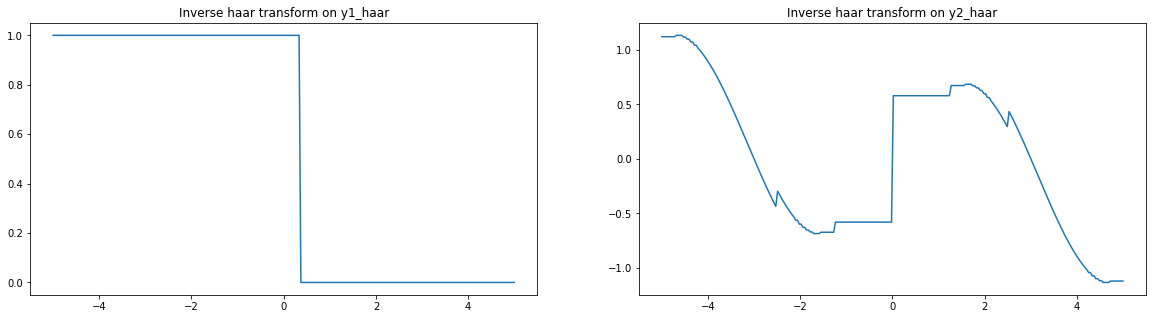

In [9]:
# Set the smallest 50% of the wavelet coefficients to zero
y1_haar[y1_haar.argsort()[:int(y1_haar.shape[0]/2)]]=0
y2_haar[y2_haar.argsort()[:int(y2_haar.shape[0]/2)]]=0

# Inverse wavelet transform
y1_inv = multilevel_idwt(y1_haar)
y2_inv = multilevel_idwt(y2_haar)

# Plot the results
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(t,y1_inv)
plt.title('Inverse haar transform on y1_haar')
plt.subplot(1,2,2)
plt.plot(t,y2_inv)
plt.title('Inverse haar transform on y2_haar')
plt.show()

Obviously, the haar wavelet transform yields a sparse representation for discontinuous signals, whereas it yields a non-sparse representation for smooth signals.